In [107]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [108]:
RANDOM_STATE = 42

# Read Data

In [109]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [110]:
read_query = make_read_query()

In [111]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value,first_order_value,first_order_categories,first_order_brands,lifetime_status,segment
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,0.0,1,1.0,74.990,74.990,74.99,[Jeans],[Wrangler],One-Off Purchaser,None
1,9418,69,F,United Kingdom,Cardiff,Search,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,0.0,2,1.0,221.500,221.500,44.00,[Intimates],[Yummie Tummie],Churn Likely,None
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,0.0,1,4.0,60.985,243.940,243.94,"[Tops & Tees, Accessories, Maternity, Blazers ...","[Patty, Modadorn, Bella Materna, FactoryExtreme]",One-Off Purchaser,None
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,0.0,2,1.0,35.975,35.975,51.96,[Fashion Hoodies & Sweatshirts],[Billabong],Churn Likely,None
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,NaN,0,NaN,NaN,NaN,NaN,None,None,Inactive,None


# EDA

In [112]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      84011 non-null  int64         
 1   age                     84011 non-null  int64         
 2   gender                  84011 non-null  object        
 3   country                 84011 non-null  object        
 4   city                    84011 non-null  object        
 5   traffic_source          84011 non-null  object        
 6   created_at              84011 non-null  datetime64[ns]
 7   first_order_timestamp   69073 non-null  datetime64[ns]
 8   last_order_timestamp    69073 non-null  datetime64[ns]
 9   days_to_activation      69073 non-null  float64       
 10  active_days             69073 non-null  float64       
 11  inactive_days           69073 non-null  float64       
 12  avg_days_to_order       30731 non-null  float6

In [113]:
users_enriched.describe()

,id,age,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,active_days,inactive_days,avg_days_to_order,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value,first_order_value
count,84011.000000,84011.000000,84011,69073,69073,69073.000000,69073.000000,69073.000000,30731.000000,69073.000000,84011.000000,69073.000000,69073.000000,69073.000000,69073.000000
mean,50064.425611,41.062706,2021-06-14 10:42:19.902130432,2022-07-16 08:15:15.045711104,2023-01-26 08:13:51.547237632,404.987101,193.778872,747.947288,275.870945,32.532509,1.490591,1.498907,59.255161,86.006317,85.800945
min,1.000000,12.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-06 02:25:41,0.000000,0.000000,388.000000,0.000000,0.000000,0.000000,1.000000,0.490000,0.490000,0.490000
25%,25108.500000,26.000000,2020-02-20 04:11:00,2021-09-13 00:20:14,2022-08-05 07:17:34,93.000000,0.000000,462.000000,83.000000,0.000000,1.000000,1.000000,30.245000,36.083333,29.500000
50%,50099.000000,41.000000,2021-05-23 03:56:00,2022-10-20 18:26:08,2023-06-03 08:41:08,284.000000,0.000000,620.000000,197.000000,0.000000,1.000000,1.000000,47.432500,64.240000,55.000000
75%,75017.500000,56.000000,2022-09-24 04:51:30,2023-07-30 10:50:57,2023-11-08 10:31:21,617.000000,269.000000,922.000000,379.000000,0.000000,2.000000,2.000000,70.982500,109.231429,109.500000
max,100000.000000,70.000000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 12:55:19.720387,1828.000000,1784.000000,2229.000000,1744.000000,1101.000000,40.000000,4.000000,999.000000,1341.490000,1341.490000
std,28864.127943,17.034090,NaN,NaN,NaN,386.041580,334.320750,366.613687,268.147382,97.142237,1.363647,0.743731,50.940926,79.785017,93.215557


In [114]:
inactive_users = users_enriched.loc[users_enriched.n_orders==0].copy()
one_off_customers = users_enriched.loc[users_enriched.n_orders==1].copy()
repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1].copy()

print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 30731 One-Off Customers 38342 Inactive Users 14938


In [115]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)
    plt.tight_layout()

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

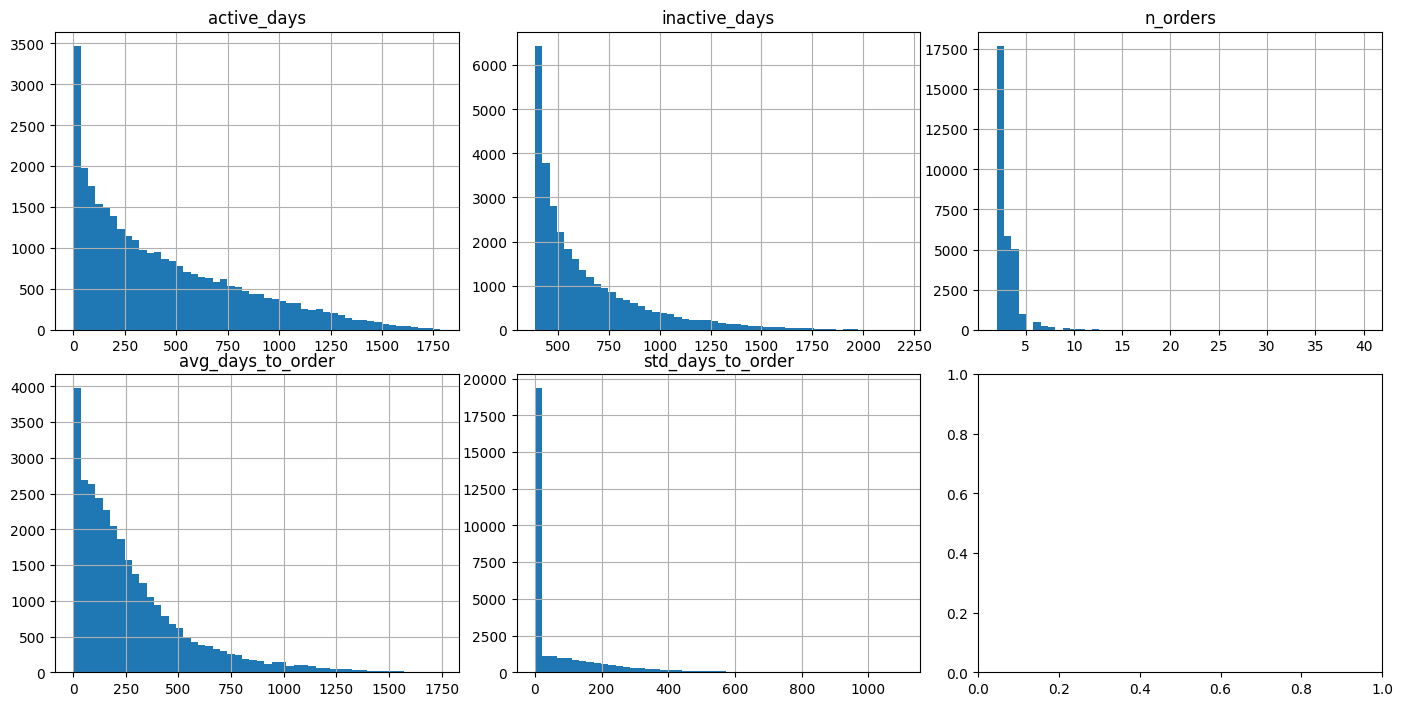

In [116]:
hist_cols = ['active_days', 'inactive_days', 'n_orders', 'avg_days_to_order', 'std_days_to_order']
plot_histograms(repeat_purchasers[hist_cols], bins=50)

In [117]:
repeat_purchasers[hist_cols].describe()

,active_days,inactive_days,n_orders,avg_days_to_order,std_days_to_order
count,30731.000000,30731.000000,30731.000000,30731.000000,30731.000000
mean,435.550031,633.841496,2.827243,275.870945,73.122189
std,381.994811,270.446420,1.384398,268.147382,135.065279
min,0.000000,388.000000,2.000000,0.000000,0.000000
25%,118.000000,435.000000,2.000000,83.000000,0.000000
50%,332.000000,535.000000,2.000000,197.000000,0.000000
75%,672.000000,742.000000,3.000000,379.000000,99.000000
max,1784.000000,2190.000000,40.000000,1744.000000,1101.000000


## Days to Order

<Axes: xlabel='active_days', ylabel='n_orders'>

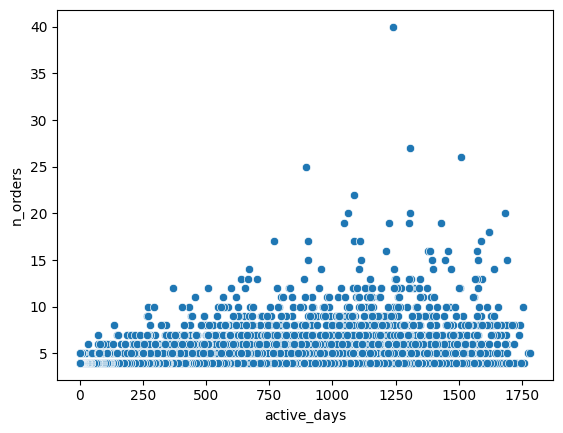

In [118]:
sns.scatterplot(repeat_purchasers[repeat_purchasers.n_orders>3], x='active_days', y='n_orders')

<Axes: xlabel='active_days', ylabel='avg_days_to_order'>

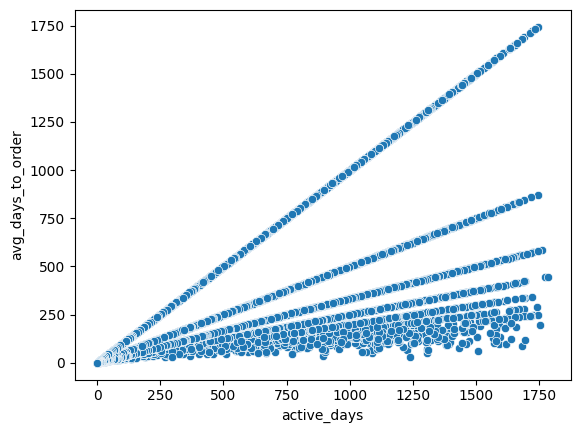

In [119]:
sns.scatterplot(repeat_purchasers, x='active_days', y='avg_days_to_order')

<Axes: xlabel='active_days', ylabel='std_days_to_order'>

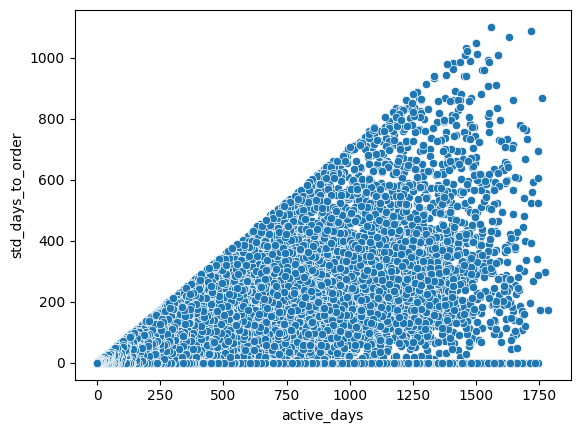

In [120]:
sns.scatterplot(repeat_purchasers, x='active_days', y='std_days_to_order')

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

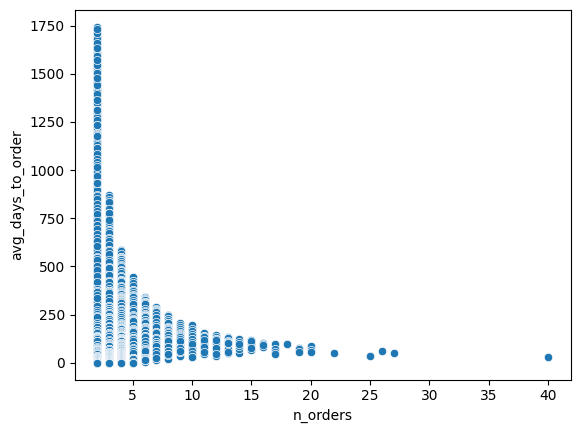

In [121]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_days_to_order')

<Axes: xlabel='n_orders', ylabel='std_days_to_order'>

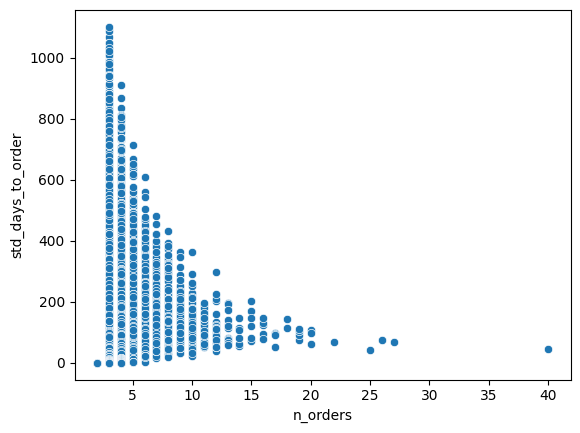

In [122]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order')

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

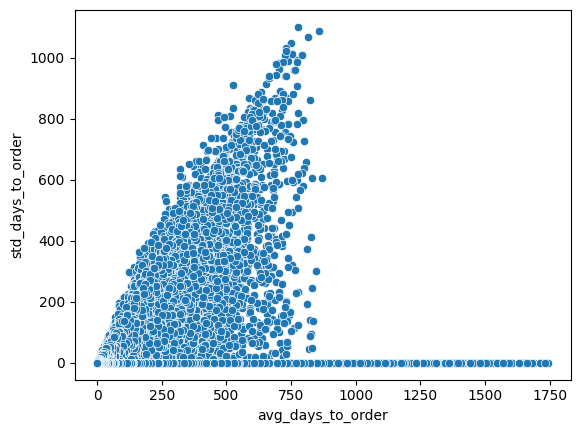

In [123]:
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='std_days_to_order')

**Observations:**
- Average and standard deviation for days to order have high upwards deviation. They both converge around a smaller mean with increasing number of orders.
- Inactive days also converges around a smaller mean with increasing number of orders.

In [124]:
repeat_purchasers_3 = repeat_purchasers.loc[repeat_purchasers.n_orders>=3]
repeat_purchasers_10 = repeat_purchasers.loc[repeat_purchasers.n_orders>=5]
repeat_purchasers_rows = repeat_purchasers.shape[0]
repeat_purchasers_rows_3 = repeat_purchasers_3.shape[0]
repeat_purchasers_rows_10 = repeat_purchasers_10.shape[0]

print('#Repeat Purchasers:', repeat_purchasers_rows, 
      '| #Repeat Purchasers (Purchesed>3):', repeat_purchasers_rows_3, 
      '| #Repeat Purchasers (Purchsed>10):', repeat_purchasers_rows_10)
print('% Repeat Purchasers (Purchsed>3):', str(round(repeat_purchasers_rows_3/repeat_purchasers_rows*100, 2))+'%',
      '| % Repeat Purchasers (Purchsed>10):', str(round(repeat_purchasers_rows_10/repeat_purchasers_rows*100, 2))+'%',)

#Repeat Purchasers: 30731 | #Repeat Purchasers (Purchesed>3): 13037 | #Repeat Purchasers (Purchsed>10): 2124
% Repeat Purchasers (Purchsed>3): 42.42% | % Repeat Purchasers (Purchsed>10): 6.91%


### Purchased >= 3

<Axes: >

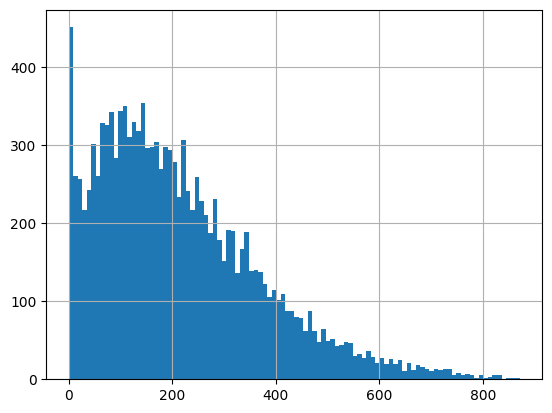

In [125]:
repeat_purchasers_3.avg_days_to_order.hist(bins=100)

<Axes: >

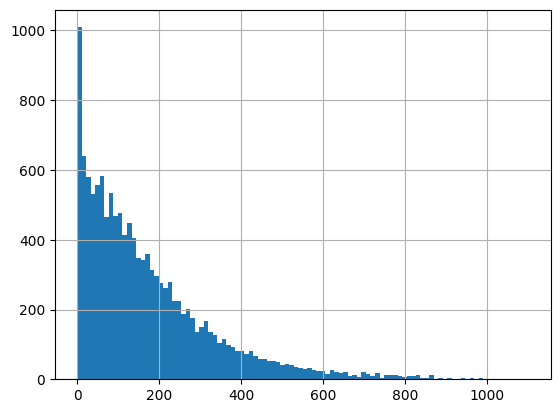

In [126]:
repeat_purchasers_3.std_days_to_order.hist(bins=100)

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

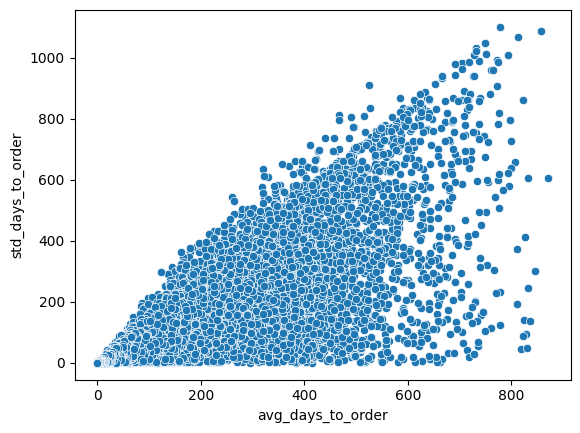

In [127]:
sns.scatterplot(repeat_purchasers_3, x='avg_days_to_order', y='std_days_to_order')

<Axes: >

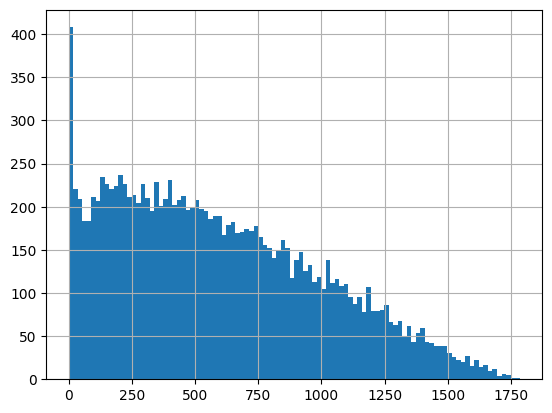

In [128]:
repeat_purchasers_3.active_days.hist(bins=100)

<Axes: xlabel='active_days', ylabel='avg_days_to_order'>

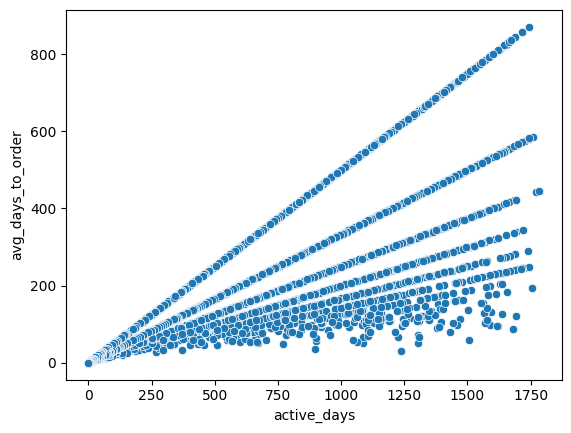

In [129]:
sns.scatterplot(repeat_purchasers_3, x='active_days', y='avg_days_to_order')

<Axes: xlabel='active_days', ylabel='std_days_to_order'>

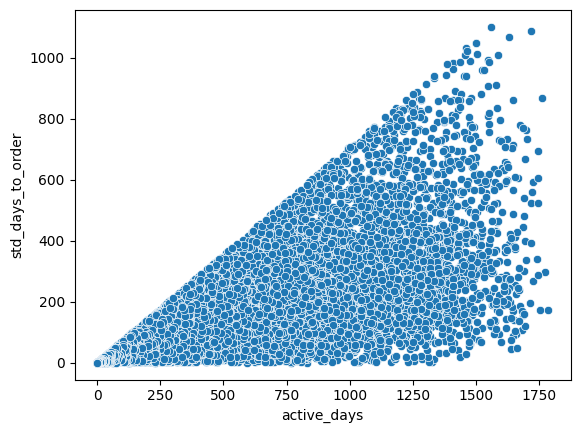

In [130]:
sns.scatterplot(repeat_purchasers_3, x='active_days', y='std_days_to_order')

### Purchased >= 10

In [131]:
repeat_purchasers_10[['avg_days_to_order', 'std_days_to_order']].describe()

,avg_days_to_order,std_days_to_order
count,2124.000000,2124.000000
mean,168.454802,168.572034
std,83.464905,107.502408
min,0.000000,1.000000
25%,107.000000,90.000000
50%,158.000000,144.000000
75%,223.000000,223.000000
max,446.000000,715.000000


<Axes: >

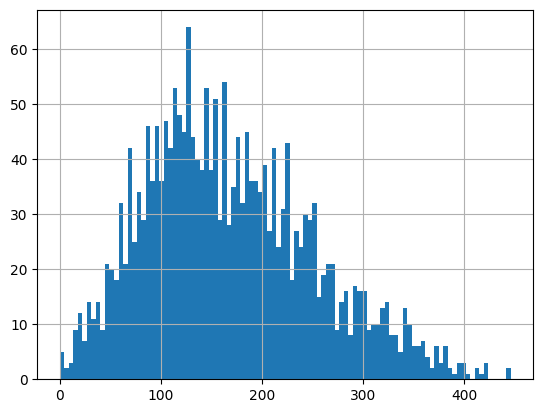

In [132]:
repeat_purchasers_10.avg_days_to_order.hist(bins=100)

<Axes: >

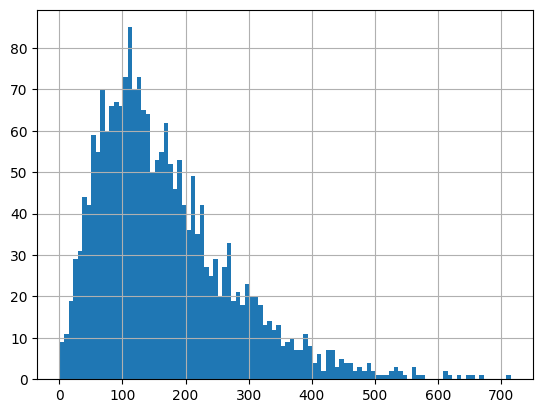

In [133]:
repeat_purchasers_10.std_days_to_order.hist(bins=100)

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

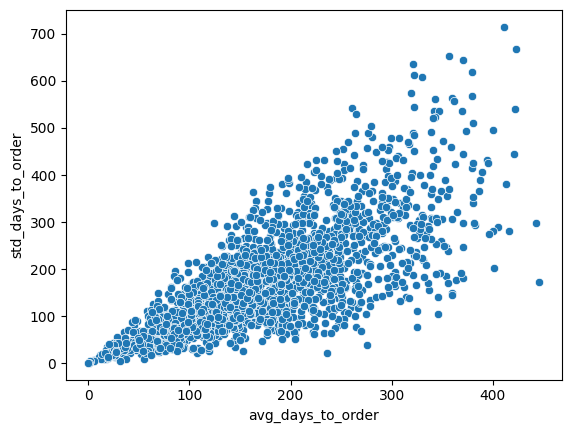

In [134]:
sns.scatterplot(repeat_purchasers_10, x='avg_days_to_order', y='std_days_to_order')

<Axes: xlabel='active_days', ylabel='avg_days_to_order'>

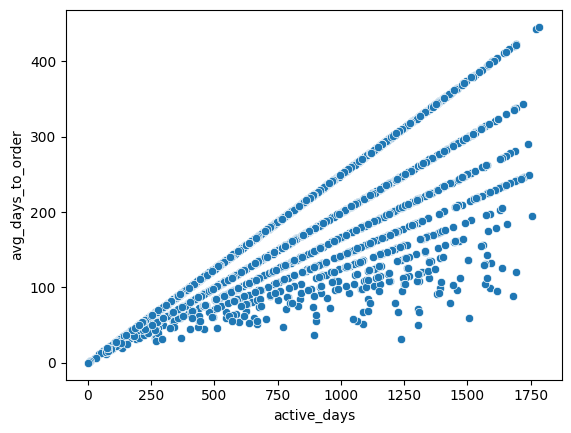

In [135]:
sns.scatterplot(repeat_purchasers_10, x='active_days', y='avg_days_to_order')

<Axes: xlabel='active_days', ylabel='std_days_to_order'>

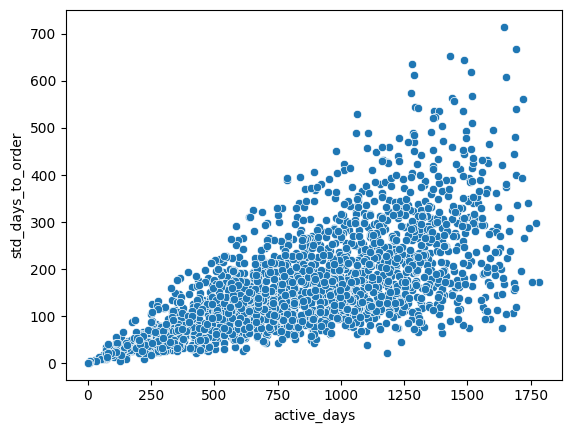

In [136]:
sns.scatterplot(repeat_purchasers_10, x='active_days', y='std_days_to_order')

# Heuristic-based Churn Flags

In [385]:
user_dto_anomalie_lims = repeat_purchasers.avg_days_to_order + 2 * repeat_purchasers.std_days_to_order
print('User Days to Order Anomalie Limits:')
print('\nHead:\n', user_dto_anomalie_lims.value_counts().head(10))
print('\nTail:\n', user_dto_anomalie_lims.value_counts().tail(10))

User Days to Order Anomalie Limits:

Head:
 0.0     483
1.0     204
3.0     185
2.0     175
6.0     105
4.0     102
8.0     102
7.0      98
5.0      97
11.0     97
Name: count, dtype: int64

Tail:
 1650.0    1
1770.0    1
1840.0    1
1851.0    1
1492.0    1
1574.0    1
1848.0    1
2047.0    1
1693.0    1
1607.0    1
Name: count, dtype: int64


In [386]:
avg_dto_anomalie_lim = repeat_purchasers.avg_days_to_order.mean() + 2 * repeat_purchasers.avg_days_to_order.std()
print('Average Days to Order Anomalie Limit:', avg_dto_anomalie_lim)

Average Days to Order Anomalie Limit: 812.1657087066421


In [387]:
repeat_purchasers['lifetime_status'] = 'Active'
churn_mask = (repeat_purchasers.inactive_days > user_dto_anomalie_lims) | (repeat_purchasers.inactive_days > 810) 
repeat_purchasers.loc[churn_mask, 'lifetime_status'] = 'Churned'

<Axes: xlabel='avg_days_to_order', ylabel='inactive_days'>

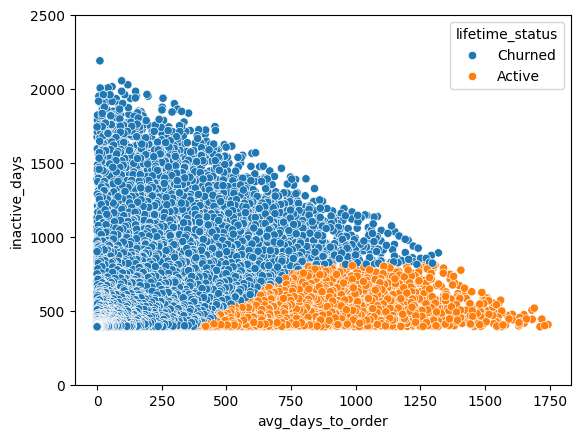

In [388]:
plt.ylim(0, 2500)
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='inactive_days', hue='lifetime_status')

<Axes: xlabel='avg_days_to_order', ylabel='inactive_days'>

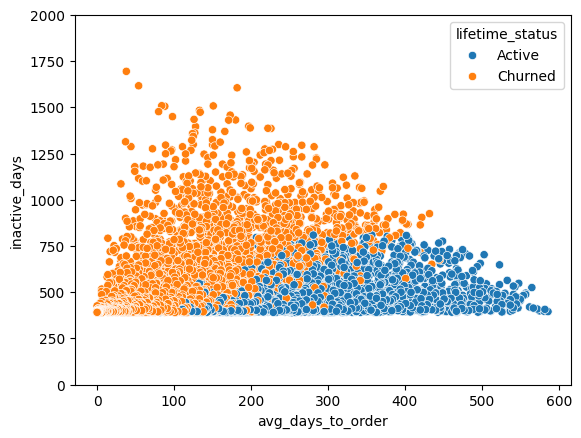

In [389]:
plt.ylim(0, 2000)
sns.scatterplot(repeat_purchasers[repeat_purchasers.n_orders>3], x='avg_days_to_order', y='inactive_days', hue='lifetime_status')

<Axes: xlabel='avg_days_to_order', ylabel='inactive_days'>

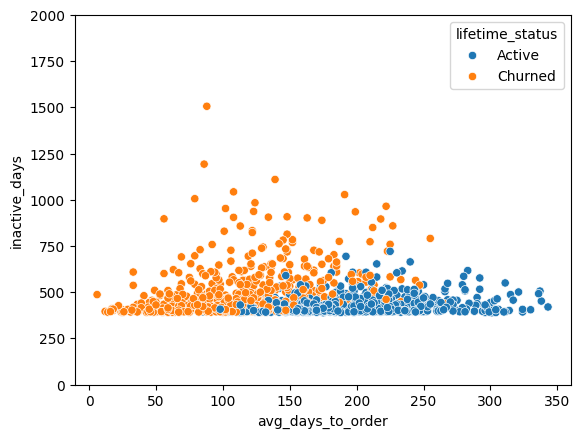

In [390]:
plt.ylim(0, 2000)
sns.scatterplot(repeat_purchasers[repeat_purchasers.n_orders>5], x='avg_days_to_order', y='inactive_days', hue='lifetime_status')

<Axes: xlabel='avg_days_to_order', ylabel='inactive_days'>

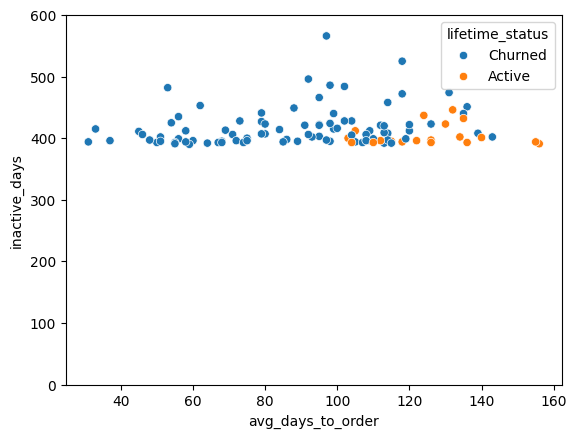

In [391]:
plt.ylim(0, 600)
sns.scatterplot(repeat_purchasers[repeat_purchasers.n_orders>10], x='avg_days_to_order', y='inactive_days', hue='lifetime_status')

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

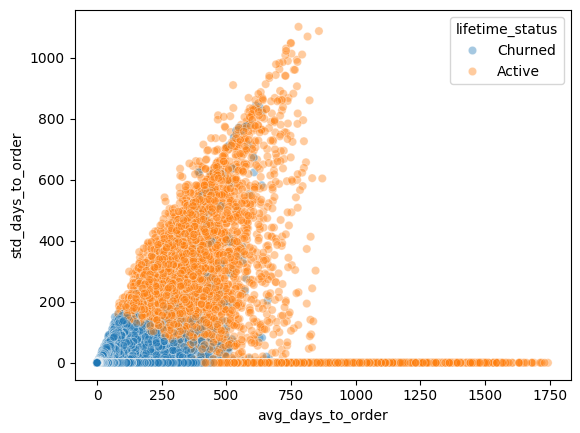

In [392]:
sns.scatterplot(repeat_purchasers, 
                x='avg_days_to_order', y='std_days_to_order', 
                hue='lifetime_status', alpha=0.4)

<Axes: xlabel='active_days', ylabel='avg_days_to_order'>

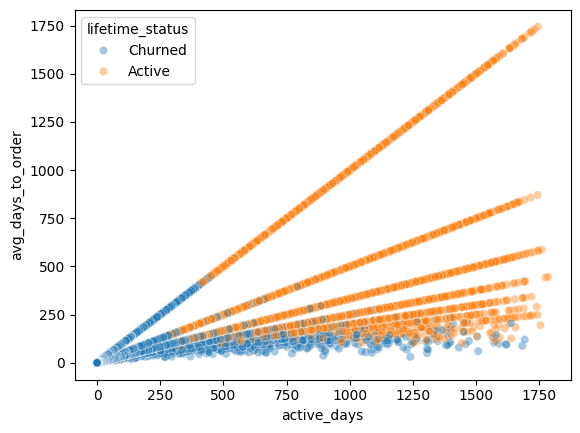

In [393]:
sns.scatterplot(repeat_purchasers, 
                x='active_days', y='avg_days_to_order', 
                hue='lifetime_status', alpha=0.4)

<Axes: xlabel='active_days', ylabel='n_orders'>

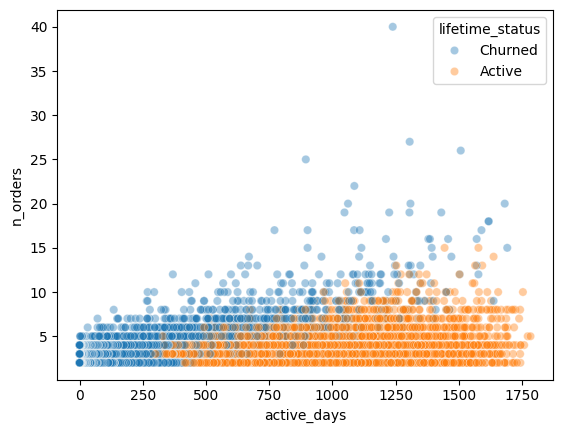

In [394]:
sns.scatterplot(repeat_purchasers, x='active_days', y='n_orders', 
                hue='lifetime_status', alpha=0.4)

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

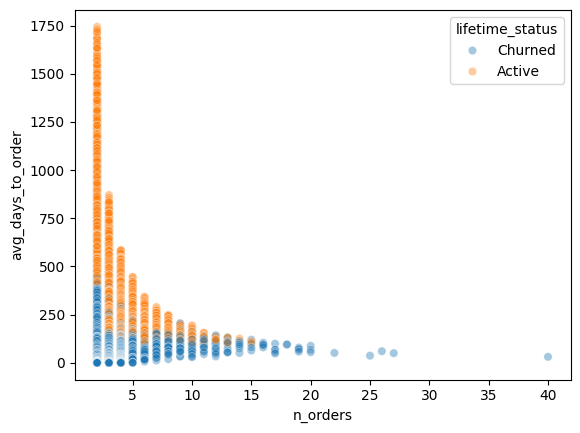

In [396]:
sns.scatterplot(repeat_purchasers, 
                x='n_orders', y='avg_days_to_order', 
                hue='lifetime_status', alpha=0.4)